# Install & Import Libraries

In [2]:
!pip install gensim 
!pip install nltk
!pip install spacy
!python -m spacy download en_core_web_sm
!pip install transformers
!pip install torch
!pip install hf_xet
!pip install bertopic

  Using cached numpy-2.2.6-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.2.6-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.5 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.6 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 36.5 MB/s eta 0:00:00a 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [7]:
pip uninstall numpy -y

Found existing installation: numpy 2.2.6
Uninstalling numpy-2.2.6:
  Successfully uninstalled numpy-2.2.6
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk.tokenize import TreebankWordTokenizer
from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import hf_xet
import spacy

In [3]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora
from gensim.models.ldaseqmodel import LdaSeqModel

# Load Data

In [4]:
df_transcripts = pd.read_csv('debate_transcripts_cleaned.csv', encoding='utf-8')

In [5]:
df_transcripts = df_transcripts[df_transcripts["is_candidate"] == True].copy()

# Add First Names of Candidates

In [6]:
candidate_first_names = {
    "Kennedy": "John",
    "Humphrey": "Hubert",
    "McGovern": "George",
    "Carter": "Jimmy",
    "Mondale": "Walter",
    "Dukakis": "Michael",
    "Clinton (Bill)": "Bill",
    "Clinton Bill": "Bill",
    "Gore": "Al",
    "Kerry": "John",
    "Obama": "Barack",
    "Clinton Hillary": "Hillary",
    "Biden": "Joe",

    "Nixon": "Richard",
    "Goldwater": "Barry",
    "Ford": "Gerald",
    "Reagan": "Ronald",
    "Bush Sr": "George",  
    "Bush Jr": "George",
    "Dole": "Bob",
    "Mccain": "John",
    "Romney": "Mitt",
    "Trump": "Donald",
    "DeSantis": "Ron",
    "Kemp": "Jack",

    "Wallace": "George",
    "Perot": "Ross",
    "Kennedy Jr.": "Robert",
    "West": "Cornel",
    "Ramaswamy": "Vivek",
    "Anderson": "John",

    "Johnson": "Lyndon",
    "Agnew": "Spiro",
    "Rockefeller": "Nelson",
    "Muskie": "Edmund",
    "Miller": "William",
    "Ferraro": "Geraldine",
    "Quayle": "Dan",
    "Lieberman": "Joe",
    "Edwards": "John",
    "Palin": "Sarah",
    "Ryan": "Paul",
    "Pence": "Mike",
    "Harris": "Kamala",
    "Cheney": "Dick",
    "Bentsen": "Lloyd",
    "Kaine": "Tim",
    "Stockdale": "James",
    "Walz": "Tim",
    "Vance": "J.D."
}

df_transcripts["first_name"] = df_transcripts["actor"].map(candidate_first_names)

In [7]:
df_transcripts.head()

,debate_title,date,year,actor,dialogue,is_candidate,party,is_winner,VP_debate,is_incumbent,first_name
0,1960_Kennedy_Nixon_1,1960-09-26,1960,Kennedy,"Mr. Smith, Mr. Nixon. In the election of 1860,...",True,Democratic,True,False,False,John
2,1960_Kennedy_Nixon_1,1960-09-26,1960,Nixon,"Mr. Smith, Senator Kennedy. The things that Se...",True,Republican,False,False,False,Richard
5,1960_Kennedy_Nixon_1,1960-09-26,1960,Kennedy,"Well, the Vice President and I came to the Con...",True,Democratic,True,False,False,John
7,1960_Kennedy_Nixon_1,1960-09-26,1960,Nixon,I have no comment.,True,Republican,False,False,False,Richard
10,1960_Kennedy_Nixon_1,1960-09-26,1960,Nixon,It would be rather difficult to cover them in ...,True,Republican,False,False,False,Richard


# Preprocess Data

In [8]:
# Download necessary resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('tokenizers')
nltk.download('punkt')

# Initialize tools
tokenizer = TreebankWordTokenizer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Preprocessing text
def text_preprocess(text):
    if pd.isnull(text):
        return ""
    tokens = tokenizer.tokenize(text)
    filtered_tokens = [word.lower() for word in tokens if word.isalpha() and word.lower() not in stop_words]
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    return " ".join(lemmatized_tokens)

# Apply to your dataframe
df_transcripts["cleaned_text"] = df_transcripts["dialogue"].apply(text_preprocess)

# Preview
df_transcripts[["dialogue", "cleaned_text"]].head(10)

[nltk_data] Downloading package stopwords to /home/ucloud/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ucloud/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Error loading tokenizers: Package 'tokenizers' not found
[nltk_data]     in index
[nltk_data] Downloading package punkt to /home/ucloud/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,dialogue,cleaned_text
0,"Mr. Smith, Mr. Nixon. In the election of 1860,...",smith election abraham lincoln said question w...
2,"Mr. Smith, Senator Kennedy. The things that Se...",smith senator thing senator kennedy said many ...
5,"Well, the Vice President and I came to the Con...",well vice president came congress together ser...
7,I have no comment.,comment
10,It would be rather difficult to cover them in ...,would rather difficult cover eight two half wo...
11,"Well, I would say in the latter that the and ...",well would say latter thats found uh somewhat ...
14,Thats correct.,thats correct
16,"Well, because I think that if the federal gove...",well think federal government moved program wi...
20,"Well, I would suggest, Mr. Vanocur, that uh i...",well would suggest vanocur uh know president p...
22,"Well, Ill just say that the question is of exp...",well ill say question experience question also...


# Remove "NON-NOUNS and NON-ADJECTIVES (POS-Tagging)

Non-Nouns and Non-Adjectives were deemed not necessary to identify topics across the political landscape

In [9]:
# Lade spaCy Modell
nlp = spacy.load("en_core_web_sm")

# Funktion zum Filtern von NOUN, ADJ, PROPN
def keep_nouns_adjectives_spacy(text):
    if pd.isnull(text):
        return ""
    doc = nlp(text)
    return " ".join([token.text.lower() for token in doc if token.pos_ in {"NOUN", "ADJ", "PROPN"}])

# Anwenden auf DataFrame
df_transcripts["cleaned_text"] = df_transcripts["cleaned_text"].apply(keep_nouns_adjectives_spacy)

# Identify and Remove "Domain-specific Stopwords"

Remove Candidate Names

In [9]:
# Step 1: Collect all lowercase actor names
actor_words_to_remove = set(df_transcripts['actor'].dropna().str.lower().str.strip())

# Step 2: Collect all lowercase first names from your mapping
first_names_to_remove = set(name.lower() for name in candidate_first_names.values())

# Step 3: Combine into one set of stopwords
names_to_remove = actor_words_to_remove.union(first_names_to_remove)
names_to_remove.update(["clinton", "bush"])

# Step 4: Define a clean-up function
def remove_names(text):
    if pd.isnull(text):
        return text
    tokens = text.split()
    cleaned_tokens = [word for word in tokens if word.lower() not in names_to_remove]
    return " ".join(cleaned_tokens)

# Step 5: Apply to cleaned_text column
df_transcripts["cleaned_text"] = df_transcripts["cleaned_text"].apply(remove_names)

Remove Words with less than 3 characters

In [10]:
def remove_short_words(text):
    if pd.isnull(text):
        return text
    tokens = text.split()
    filtered_tokens = [word for word in tokens if len(word) >= 3]
    return " ".join(filtered_tokens)

df_transcripts["cleaned_text"] = df_transcripts["cleaned_text"].apply(remove_short_words)

Identify Frequent Words without Topic Contribution

In [32]:
from collections import Counter
import pandas as pd

# Combine all cleaned text into one long string
all_text = " ".join(df_transcripts["cleaned_text"].dropna())

# Split into words
words = all_text.split()

# Count frequency
word_counts = Counter(words)

# Get the 200 most common words
top_300_df = word_counts.most_common(300)

# Ensure all rows are shown
pd.set_option('display.max_rows', 300)

# Display interactively
top_300_df

[('tax', 1656),
 ('right', 1086),
 ('job', 949),
 ('first', 869),
 ('cut', 768),
 ('plan', 742),
 ('new', 694),
 ('work', 683),
 ('care', 635),
 ('money', 622),
 ('health', 620),
 ('family', 572),
 ('program', 558),
 ('security', 523),
 ('war', 506),
 ('pay', 498),
 ('help', 497),
 ('business', 472),
 ('nation', 468),
 ('economy', 462),
 ('child', 457),
 ('support', 411),
 ('nuclear', 408),
 ('school', 394),
 ('military', 378),
 ('woman', 377),
 ('deal', 369),
 ('cost', 362),
 ('budget', 359),
 ('national', 345),
 ('energy', 345),
 ('economic', 343),
 ('life', 343),
 ('ill', 334),
 ('law', 333),
 ('spending', 332),
 ('dollar', 331),
 ('education', 330),
 ('record', 326),
 ('rate', 310),
 ('home', 310),
 ('weapon', 304),
 ('middle', 303),
 ('system', 300),
 ('use', 299),
 ('drug', 297),
 ('increase', 291),
 ('medicare', 287),
 ('company', 273),
 ('course', 271),
 ('troop', 268),
 ('iraq', 268),
 ('hope', 265),
 ('foreign', 259),
 ('force', 256),
 ('position', 250),
 ('public', 247),
 ('

 Remove President Names:

In [12]:
# STEP 4: Collect lowercase actor names to remove as well
actor_words_to_remove = set(df_transcripts['actor'].dropna().str.lower().str.strip())

In [13]:
from collections import Counter

# STEP 1: Collect top 300 most frequent words
all_text = " ".join(df_transcripts["cleaned_text"].dropna())
top_words = [word for word, _ in Counter(all_text.split()).most_common(300)]

# STEP 2: Define exception list (keep these even if frequent)
exception_words = {
    "tax", "job", "health", "money", "care", "family", "plan", "program",
    "security", "war", "business", "nation", "economy", "work", "child", "school", "woman", "budget", "energy",
    "life", "law", "dollar", "education", "cut", "rate", "record", "system", "weapon", "drug", "deal", "company",
    "iraq", "troop", "support", "home", "cost", "oil", "force", "course", "defense", "opportunity", "position",
    "reform", "deficit", "medicare", "china", "iran", "man", "leadership", "election", "insurance", "income",
    "control", "house", "trade", "case", "kid", "hope", "power", "increase", "credit", "line", "community", "peace",
    "union", "soviet", "russia", "ally", "court", "folk", "growth", "spending", "agreement", "debt", "freedom",
    "city", "order", "effort", "border", "chance", "class", "college", "new", "teacher", "action", "value", "threat",
    "act", "parent", "strength", "afghanistan", "gun", "crime", "inflation", "member", "arm", "commitment",
    "experience", "first", "help", "side", "unemployment", "group", "israel", "price", "others", "level", "middle",
    "taxpayer", "market", "worker", "ill", "pay", "street", "national", "justice", "trust", "saddam", "citizen",
    "north", "jim", "white", "investment", "benefit", "men", "housing", "fund", "east", "service",
    "sanction", "abortion", "police", "use", "crisis", "regard", "progress", "industry", "judge", "right",
    "military", "land", "attack", "period", "amendment", "mistake", "opponent", "legislation", "welfare", "call",
    "nuclear", "bin", "enforcement", "korea", "priority", "air", "regulation", "love", "aid", "intelligence",
    "prescription", "coal", "son", "hussein", "wall", "couple", "relationship", "result", "rest", "supreme",
    "europe", "mother", "doctor", "putin", "student", "sense", "missile", "technology", "gas",
    "belief", "environment", "resource", "balance", "fight", "faith", "role", "race", "loan", "head", "food",
    "recession", "treaty", "capital", "plant", "car", "development", "incentive", "california", "product", "welfare", "foreign", "economic", "ill", "public", "white", "russian", "human"
}

# STEP 3: Compute frequent words to remove (exclude exceptions)
frequent_words_to_remove = set(top_words) - exception_words

# STEP 4: Add lowercase actor names to removal list
actor_words_to_remove = set(df_transcripts["actor"].dropna().str.lower().str.strip())

# Optional STEP 5: Define extra political terms (if you intend to use this)
political_terms = set()  # or define as: {"president", "candidate", "campaign", ...}

# STEP 6: Combine all words to remove (lowercase)
words_to_remove = frequent_words_to_remove.union(political_terms).union(actor_words_to_remove)

# STEP 7: Clean function with case-insensitive filtering
def clean_with_exceptions(text):
    if pd.isnull(text):
        return ""
    tokens = text.split()
    filtered_tokens = [word for word in tokens if word.lower() not in words_to_remove]
    return " ".join(filtered_tokens)

# STEP 8: Apply to DataFrame
df_transcripts["cleaned_text"] = df_transcripts["cleaned_text"].apply(clean_with_exceptions)

# STEP 9: Preview result
df_transcripts[["actor", "dialogue", "cleaned_text"]].head(10)

,actor,dialogue,cleaned_text
0,Kennedy,"Mr. Smith, Mr. Nixon. In the election of 1860,...",smith election abraham lincoln nation exist el...
2,Nixon,"Mr. Smith, Senator Kennedy. The things that Se...",smith discus internal affair recognizing treme...
5,Kennedy,"Well, the Vice President and I came to the Con...",served labor fourteen period experience second...
7,Nixon,I have no comment.,comment
10,Nixon,It would be rather difficult to cover them in ...,rather difficult cover suggest proposal first ...
11,Kennedy,"Well, I would say in the latter that the and ...",latter found somewhat unsatisfactory figure pr...
14,Kennedy,Thats correct.,correct
16,Kennedy,"Well, because I think that if the federal gove...",moved program withdrew support complete econom...
20,Nixon,"Well, I would suggest, Mr. Vanocur, that uh i...",suggest vanocur probably facetious suggest ins...
22,Kennedy,"Well, Ill just say that the question is of exp...",ill experience judgment goal ability implement...


In [14]:
# Drop rows where cleaned_text is empty or just whitespace
df_transcripts = df_transcripts[df_transcripts["cleaned_text"].str.strip() != ""]

# Reset index if desired
df_transcripts.reset_index(drop=True, inplace=True)

# Preview the result
df_transcripts.head(10)

,debate_title,date,year,actor,dialogue,is_candidate,party,is_winner,VP_debate,is_incumbent,first_name,cleaned_text
0,1960_Kennedy_Nixon_1,1960-09-26,1960,Kennedy,"Mr. Smith, Mr. Nixon. In the election of 1860,...",True,Democratic,True,False,False,John,smith election abraham lincoln nation exist el...
1,1960_Kennedy_Nixon_1,1960-09-26,1960,Nixon,"Mr. Smith, Senator Kennedy. The things that Se...",True,Republican,False,False,False,Richard,smith discus internal affair recognizing treme...
2,1960_Kennedy_Nixon_1,1960-09-26,1960,Kennedy,"Well, the Vice President and I came to the Con...",True,Democratic,True,False,False,John,served labor fourteen period experience second...
3,1960_Kennedy_Nixon_1,1960-09-26,1960,Nixon,I have no comment.,True,Republican,False,False,False,Richard,comment
4,1960_Kennedy_Nixon_1,1960-09-26,1960,Nixon,It would be rather difficult to cover them in ...,True,Republican,False,False,False,Richard,rather difficult cover suggest proposal first ...
5,1960_Kennedy_Nixon_1,1960-09-26,1960,Kennedy,"Well, I would say in the latter that the and ...",True,Democratic,True,False,False,John,latter found somewhat unsatisfactory figure pr...
6,1960_Kennedy_Nixon_1,1960-09-26,1960,Kennedy,Thats correct.,True,Democratic,True,False,False,John,correct
7,1960_Kennedy_Nixon_1,1960-09-26,1960,Kennedy,"Well, because I think that if the federal gove...",True,Democratic,True,False,False,John,moved program withdrew support complete econom...
8,1960_Kennedy_Nixon_1,1960-09-26,1960,Nixon,"Well, I would suggest, Mr. Vanocur, that uh i...",True,Republican,False,False,False,Richard,suggest vanocur probably facetious suggest ins...
9,1960_Kennedy_Nixon_1,1960-09-26,1960,Kennedy,"Well, Ill just say that the question is of exp...",True,Democratic,True,False,False,John,ill experience judgment goal ability implement...


In [24]:
%pip uninstall -y gensim numpy

Found existing installation: gensim 4.3.3
Uninstalling gensim-4.3.3:
  Successfully uninstalled gensim-4.3.3
Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Note: you may need to restart the kernel to use updated packages.


In [25]:
%pip install numpy==1.26.4

  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.0 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [26]:
%pip install gensim==4.3.1

  Using cached gensim-4.3.1.tar.gz (23.3 MB)
  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'gensim' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'gensim'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [756 lines of output]
      /opt/conda/lib/python3.12/site-packages/setuptools/__init__.py:94: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
      !!
      
              ********************************************************************************
              Requirements should be satisfied by 

In [16]:
from gensim import corpora

# Step 1: Tokenize cleaned text
texts = df_transcripts["cleaned_text"].dropna().apply(str.split).tolist()

# Step 2: Create dictionary from tokenized texts
dictionary = corpora.Dictionary(texts)

# Step 3: Filter extremes
dictionary.filter_extremes(no_below=5, no_above=0.3)

# Step 4: Print number of remaining tokens
print(f"Remaining tokens after filtering: {len(dictionary)}")

Remaining tokens after filtering: 2533


# Topic Modeling using LDA

Assumption: Each Speech is treated as a Document

In [26]:
import gensim
from gensim.models import CoherenceModel
from gensim import corpora
from gensim.models import LdaModel
import pandas as pd

# Step 1: Tokenize cleaned text
texts = df_transcripts["cleaned_text"].dropna().apply(str.split).tolist()

# Step 2: Create dictionary and corpus
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Step 3: Train LDA model
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=15, random_state=42, passes=100)

# Step 4: Show all topics
all_topics = lda_model.show_topics(num_topics=-1, num_words=10, formatted=True)

for topic_id, topic_words in all_topics:
    print(f"Topic {topic_id}: {topic_words}")

Topic 0: 0.080*"security" + 0.064*"social" + 0.029*"penny" + 0.012*"trust" + 0.010*"medicare" + 0.009*"committee" + 0.009*"benefit" + 0.008*"inaudible" + 0.008*"iranian" + 0.008*"release"
Topic 1: 0.042*"world" + 0.031*"nuclear" + 0.019*"nation" + 0.019*"iran" + 0.017*"war" + 0.016*"soviet" + 0.015*"weapon" + 0.015*"russia" + 0.012*"middle" + 0.011*"peace"
Topic 2: 0.069*"health" + 0.069*"care" + 0.031*"plan" + 0.026*"drug" + 0.026*"insurance" + 0.023*"family" + 0.022*"cost" + 0.021*"medicare" + 0.015*"reform" + 0.015*"government"
Topic 3: 0.023*"word" + 0.020*"trade" + 0.020*"vote" + 0.012*"guy" + 0.011*"car" + 0.011*"open" + 0.010*"agreement" + 0.009*"liberal" + 0.008*"history" + 0.008*"latin"
Topic 4: 0.040*"woman" + 0.034*"issue" + 0.032*"court" + 0.023*"abortion" + 0.018*"decision" + 0.018*"statement" + 0.017*"supreme" + 0.015*"voter" + 0.014*"gentleman" + 0.014*"judge"
Topic 5: 0.029*"joe" + 0.021*"law" + 0.013*"black" + 0.012*"hillary" + 0.011*"ill" + 0.011*"young" + 0.010*"prou

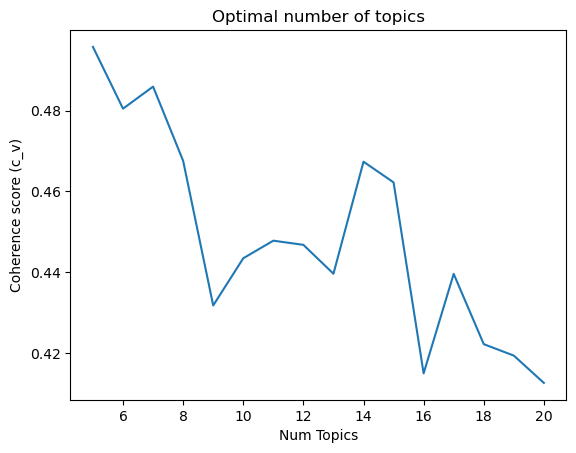

In [13]:
coherence_values = []
topic_range = range(5, 21, 1)

for num_topics in topic_range:
    model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42)
    coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())

# Plot coherence scores
import matplotlib.pyplot as plt
plt.plot(topic_range, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score (c_v)")
plt.title("Optimal number of topics")
plt.show()

In [28]:
import pandas as pd
from collections import defaultdict

topic_labels = {
    0:  "Social Security, Medicare & Middle East Relations",
    1:  "Nuclear Policy, Global Diplomacy & Foreign Threats",
    2:  "Healthcare, Insurance Reform & Medical Costs",
    3:  "Trade Agreements, Voting & Political Rhetoric",
    4:  "Abortion Rights, Supreme Court Decisions & Gender Issues",
    5:  "Candidate Identity, Personal Narratives & Social Justice",
    6:  "Gun Violence, Crime Policy & Debate Proceedings",
    7:  "Government Programs, Urban Policy & Systemic Challenges",
    8:  "Immigration, Border Policy & Vice Presidential Debate Focus",
    9:  "Military Intervention, Defense Strategy & War in the Middle East",
    10: "Education, Youth Programs & Community Development",
    11: "China Policy, Global Trade & Public Reactions",
    12: "Debate Moments, Rhetoric & Voter Sentiment",
    13: "Energy Policy, Fossil Fuels & Clean Technology",
    14: "Taxation, Economic Growth & Fiscal Strategy"
}

# Step 1: Create mapping from document index to year
doc_years = df_transcripts["year"].reset_index(drop=True)

# Step 2: Get topic distribution for each document
doc_topics = lda_model.get_document_topics(corpus, minimum_probability=0.0)

# Step 3: Aggregate topic weights by year
year_topic_weights = defaultdict(lambda: [0.0] * lda_model.num_topics)

for doc_id, topic_dist in enumerate(doc_topics):
    year = doc_years[doc_id]
    for topic_id, weight in topic_dist:
        year_topic_weights[year][topic_id] += weight

# Step 4: Convert to DataFrame
year_topic_df = pd.DataFrame.from_dict(year_topic_weights, orient='index')
year_topic_df.index.name = "year"
year_topic_df.columns = [topic_labels.get(i, f"Topic {i}") for i in range(lda_model.num_topics)]

# Step 5: Normalize topic weights per year
year_topic_df = year_topic_df.div(year_topic_df.sum(axis=1), axis=0)

# Step 6: Preview
print(year_topic_df.round(3).head(10))

      Social Security, Medicare & Middle East Relations  \
year                                                      
1960                                              0.043   
1976                                              0.058   
1980                                              0.076   
1984                                              0.062   
1988                                              0.056   
1992                                              0.035   
1996                                              0.053   
2000                                              0.050   
2004                                              0.037   
2008                                              0.049   

      Nuclear Policy, Global Diplomacy & Foreign Threats  \
year                                                       
1960                                              0.119    
1976                                              0.122    
1980                                              0

/tmp/ipykernel_354/3485045084.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20', year_topic_df.shape[1]).colors


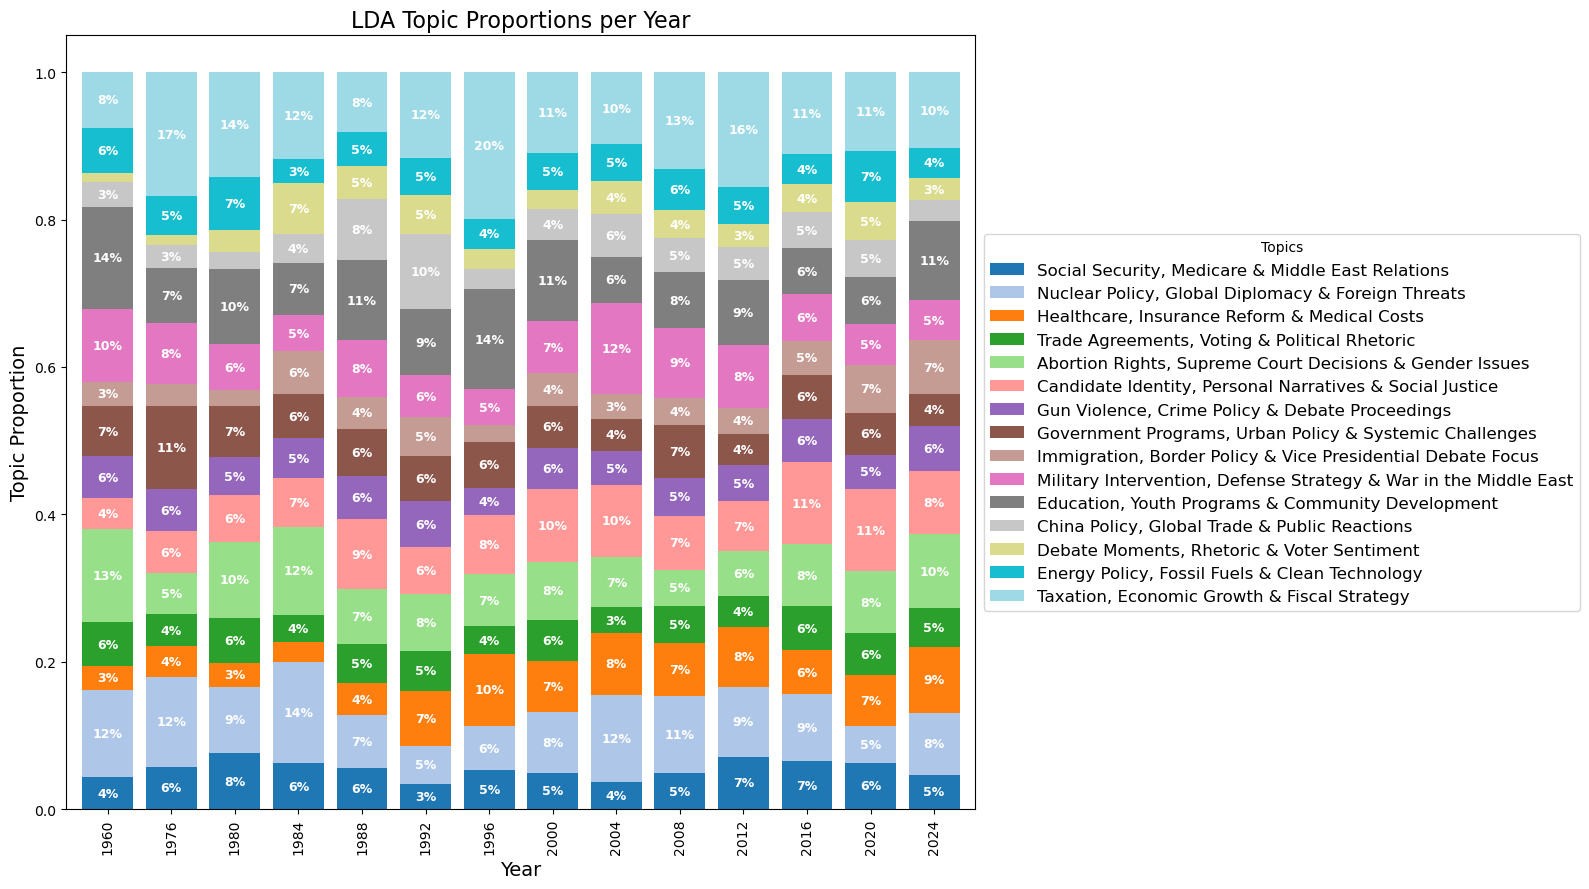

In [29]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Optional: Sort years
year_topic_df = year_topic_df.sort_index()

# Create colormap
colors = cm.get_cmap('tab20', year_topic_df.shape[1]).colors

# Plot settings
fig, ax = plt.subplots(figsize=(16, 9))
bars = year_topic_df.plot(
    kind='bar',
    stacked=True,
    color=colors,
    width=0.8,
    ax=ax
)

# Add percentage labels
for i, year in enumerate(year_topic_df.index):
    y_offset = 0
    for j, topic in enumerate(year_topic_df.columns):
        value = year_topic_df.loc[year, topic]
        if value > 0.03:  # Only label if > 3% for readability
            ax.text(
                i,
                y_offset + value / 2,
                f"{value:.0%}",
                ha='center',
                va='center',
                fontsize=9,
                color='white',
                weight='bold'
            )
        y_offset += value

# Labels and legend
ax.set_title("LDA Topic Proportions per Year", fontsize=16)
ax.set_xlabel("Year", fontsize=14)
ax.set_ylabel("Topic Proportion", fontsize=14)
ax.legend(
    loc='center left',
    bbox_to_anchor=(1.0, 0.5),
    title="Topics",
    fontsize=12
)

plt.tight_layout()
plt.show()

# Dynamic Topic Modelling

## Create Topic Model

In [15]:
# Step 1: Preprocessing - tokenize and filter short texts
df_transcripts = df_transcripts.dropna(subset=["cleaned_text"])
df_transcripts["tokens"] = df_transcripts["cleaned_text"].apply(lambda x: x.split())

# Step 2: Group token lists by year
grouped = df_transcripts.groupby("year")["tokens"].apply(list).sort_index()

# Step 3: Flatten into one doc per speech (not per year!)
all_docs = [doc for year_docs in grouped for doc in year_docs]
timeslices = [len(year_docs) for year_docs in grouped]

# Step 4: Dictionary + filtering
dictionary = corpora.Dictionary(all_docs)
corpus = [dictionary.doc2bow(text) for text in all_docs]

# Step 5: Train Dynamic Topic Model (default/full settings)
ldaseq = LdaSeqModel(
    corpus=corpus,
    time_slice=timeslices,
    id2word=dictionary,
    num_topics=7,
    initialize='gensim',
    random_state=42
)

# Step 6: Print top terms in each topic over time
for topic_id in range(7):
    print(f"\n=== Topic {topic_id} ===")
    for t, year in enumerate(grouped.index):
        terms = ldaseq.print_topic(topic=topic_id, time=t, top_terms=10)
        print(f"Year {year}: {terms}")

/opt/conda/lib/python3.12/site-packages/gensim/models/ldaseqmodel.py:298: RuntimeWarning: divide by zero encountered in scalar divide
  convergence = np.fabs((bound - old_bound) / old_bound)



=== Topic 0 ===
Year 1960: [('school', 0.021850039166152347), ('education', 0.01555572554140152), ('money', 0.01271966547873307), ('house', 0.012274329129773694), ('teacher', 0.011299003439908799), ('budget', 0.010999591543094503), ('child', 0.009990160733145417), ('public', 0.008963400593689892), ('dollar', 0.00811396832428471), ('program', 0.007822863447191556)]
Year 1976: [('school', 0.02119838339960007), ('education', 0.015106309169543116), ('money', 0.012596413759233026), ('house', 0.012057888614271236), ('budget', 0.01107935554419161), ('teacher', 0.010414996793347127), ('child', 0.010133994953406934), ('public', 0.009219065412013604), ('dollar', 0.007942033754273263), ('program', 0.007897277149358919)]
Year 1980: [('school', 0.021673899492481025), ('education', 0.014720119246663058), ('money', 0.012455438122780507), ('house', 0.011201956569358372), ('budget', 0.011035219918667736), ('child', 0.010412622447097548), ('teacher', 0.009914741289995626), ('public', 0.0095143388309462

## Find Optimal Number of Topics 

In [17]:
from gensim.models import LdaModel, CoherenceModel

# Prepare corpus and dictionary (you already have these)
texts = all_docs  # your tokenized documents
corpus = [dictionary.doc2bow(text) for text in texts]

# Try a range of topic numbers
topic_range = range(3, 21)  # You can adjust range
coherence_scores = []

for num_topics in topic_range:
    lda_model = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        passes=10,
        random_state=42
    )
    coherence_model = CoherenceModel(
        model=lda_model,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    coherence = coherence_model.get_coherence()
    coherence_scores.append(coherence)

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(topic_range, coherence_scores, marker='o')
plt.title("Optimal Number of Topics (Static LDA Proxy)")
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score (c_v)")
plt.grid(True)
plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

## Plot Topic Developments

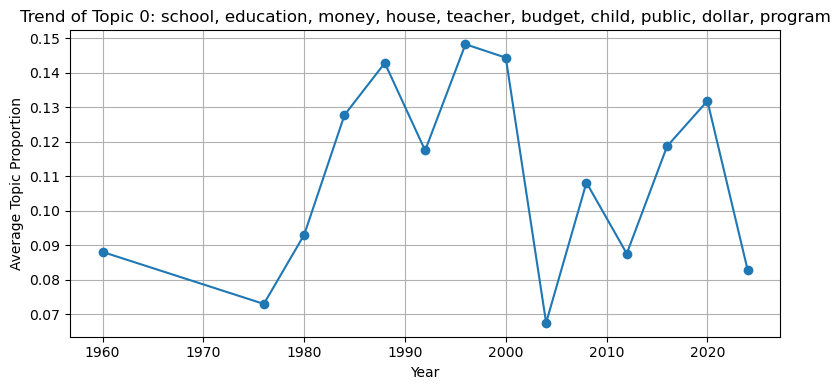

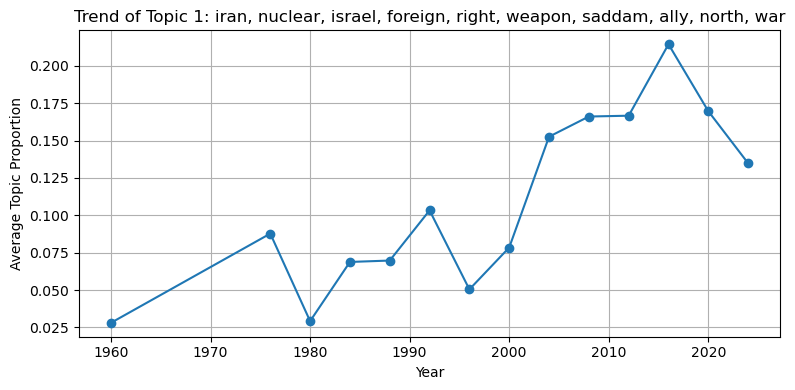

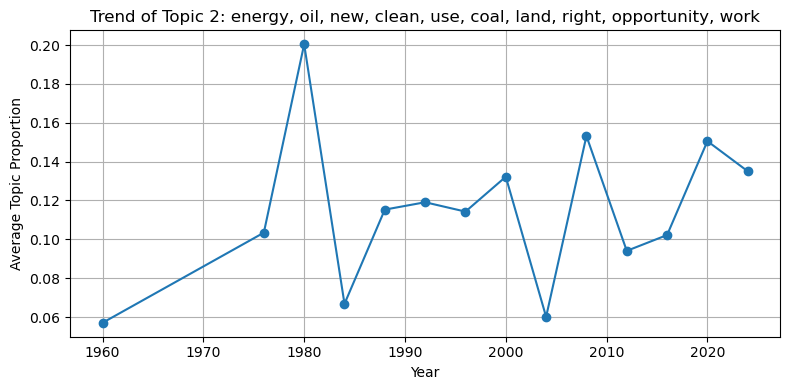

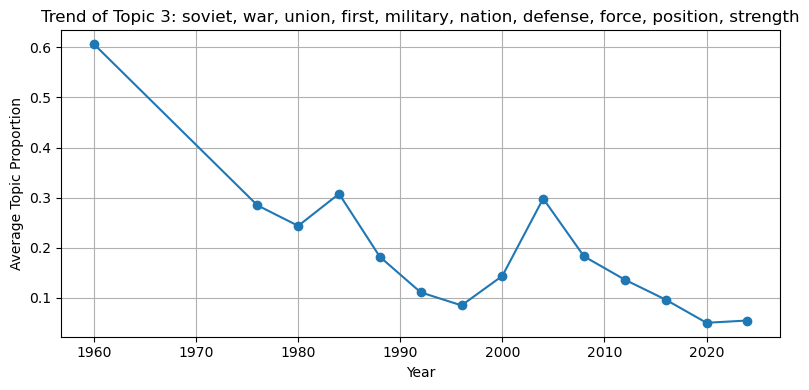

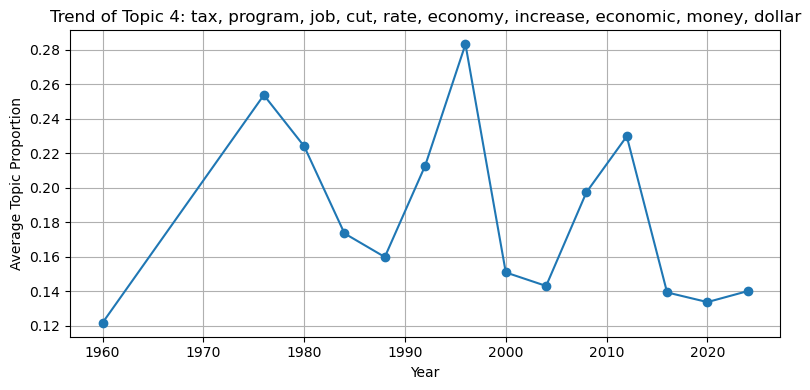

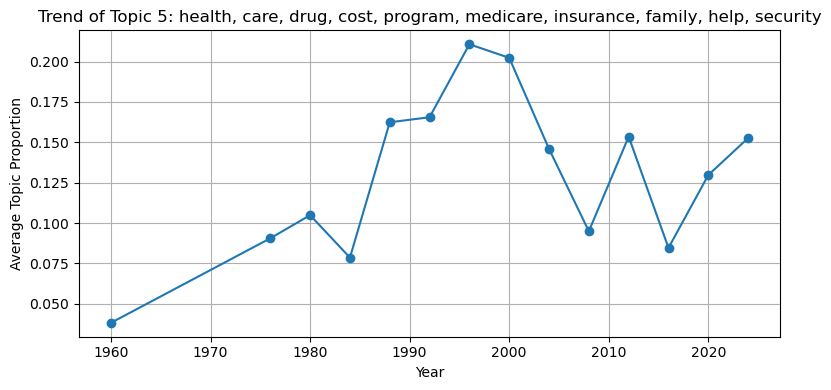

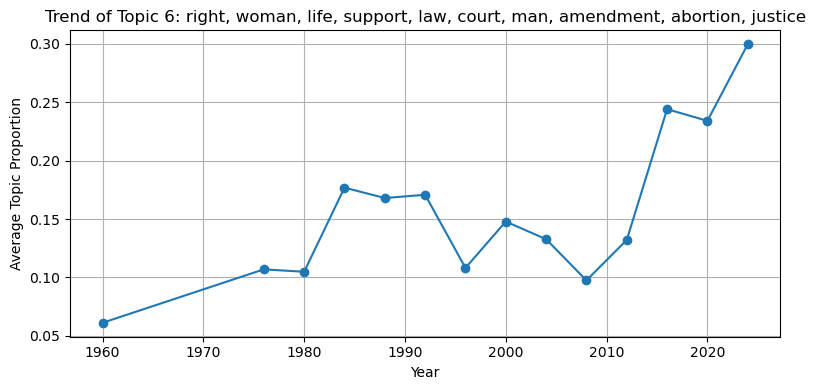

In [20]:
import matplotlib.pyplot as plt

# Step 1: Get topic proportions per document
doc_topic_dists = [ldaseq.doc_topics(i) for i in range(len(all_docs))]
topic_df = pd.DataFrame(doc_topic_dists, columns=[f"Topic {i}" for i in range(ldaseq.num_topics)])

# Step 2: Match each doc to its year
years_per_doc = []
for year, docs in grouped.items():
    years_per_doc.extend([year] * len(docs))
topic_df["year"] = years_per_doc

# Step 3: Average topic proportions per year
topic_trends = topic_df.groupby("year").mean()

# Step 4: Get top 10 terms per topic (from first time slice)
topic_labels = []
for topic_id in range(ldaseq.num_topics):
    top_terms = ldaseq.print_topic(topic=topic_id, time=0, top_terms=10)
    label = f"Topic {topic_id}: " + ", ".join([term for term, _ in top_terms])
    topic_labels.append(label)

# Step 5: Plot each topic separately
for i, col in enumerate(topic_trends.columns):
    plt.figure(figsize=(8, 4))
    plt.plot(topic_trends.index, topic_trends[col], marker='o')
    plt.title(f"Trend of {topic_labels[i]}")
    plt.xlabel("Year")
    plt.ylabel("Average Topic Proportion")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

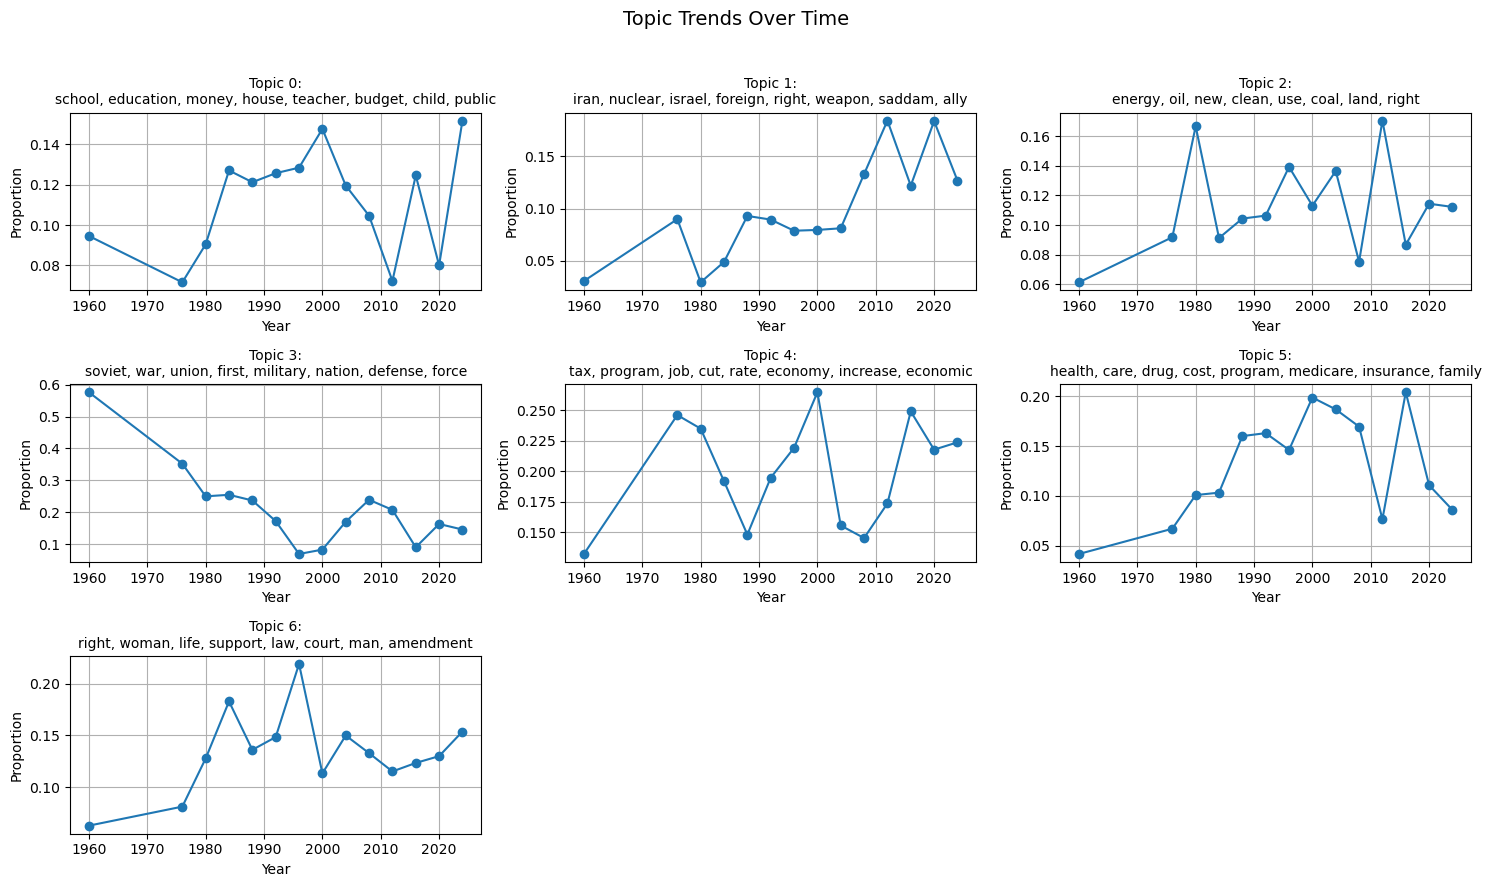

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Get topic proportions per document
doc_topic_dists = [ldaseq.doc_topics(i) for i in range(len(all_docs))]
topic_df = pd.DataFrame(doc_topic_dists, columns=[f"Topic {i}" for i in range(ldaseq.num_topics)])

# Step 2: Match each doc to its year
years_per_doc = []
for year, docs in grouped.items():
    years_per_doc.extend([year] * len(docs))
topic_df["year"] = years_per_doc

# Step 3: Average topic proportions per year
topic_trends = topic_df.groupby("year").mean()

# Step 4: Get top 5 terms per topic (from first time slice)
topic_labels = []
for topic_id in range(ldaseq.num_topics):
    top_terms = ldaseq.print_topic(topic=topic_id, time=0, top_terms=8)
    label = f"Topic {topic_id}:\n" + ", ".join([term for term, _ in top_terms])
    topic_labels.append(label)

# Step 5: Plot in grid (e.g. 2 rows x 4 columns for 7–8 topics)
n_topics = ldaseq.num_topics
n_rows = (n_topics + 2) // 3  # adjust as needed
n_cols = 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 3))
axes = axes.flatten()

for i in range(n_topics):
    ax = axes[i]
    ax.plot(topic_trends.index, topic_trends[f"Topic {i}"], marker='o')
    ax.set_title(topic_labels[i], fontsize=10)
    ax.set_xlabel("Year")
    ax.set_ylabel("Proportion")
    ax.grid(True)

# Hide any unused subplots
for j in range(n_topics, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Topic Trends Over Time", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## Create Topic Word Lists

In [24]:
# Extract top 30 terms per topic from the first time slice
topic_keywords = {}

for topic_id in range(ldaseq.num_topics):
    top_terms = ldaseq.print_topic(topic=topic_id, time=0, top_terms=30)
    words_only = [term for term, _ in top_terms]
    topic_keywords[f"Topic {topic_id}"] = words_only

# Convert to DataFrame
topic_keywords_df = pd.DataFrame.from_dict(topic_keywords, orient='index').transpose()

# Show the full DataFrame
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Display
print(topic_keywords_df)

      Topic 0       Topic 1        Topic 2     Topic 3       Topic 4  \
0      school          iran         energy      soviet           tax   
1   education       nuclear            oil         war       program   
2       money        israel            new       union           job   
3       house       foreign          clean       first           cut   
4     teacher         right            use    military          rate   
5      budget        weapon           coal      nation       economy   
6       child        saddam           land     defense      increase   
7      public          ally          right       force      economic   
8      dollar         north    opportunity    position         money   
9     program           war           work    strength        dollar   
10      first        middle            job       peace           pay   
11   spending        russia          first    security        growth   
12      white          true            gun     freedom        bu

## Explore Semantic Shifts

In [29]:
# Parameters
topic_id = 3      # Topic to inspect
top_n = 15        # Top N words to extract

# Ensure 'grouped' is defined and sorted by year
years = list(grouped.index)

# Dictionary to store results
topic3_words_by_year = {}

# Loop over each time slice (year)
for t, year in enumerate(years):
    terms = ldaseq.print_topic(topic=topic_id, time=t, top_terms=top_n)
    topic3_words_by_year[year] = [term for term, _ in terms]

# Convert to DataFrame
topic3_evolution_df = pd.DataFrame.from_dict(topic3_words_by_year, orient='index').transpose()
topic3_evolution_df.index.name = "Top Term Rank"

# Display the result
print(topic3_evolution_df)

                   1960        1976      1980        1984        1988  \
Top Term Rank                                                           
0                soviet      soviet    soviet      soviet         war   
1                   war         war       war         war      soviet   
2                 union    military  military    military    military   
3                 first      nation    nation     defense     defense   
4              military       union   defense       force       force   
5                nation     defense     union      nation      nation   
6               defense       first     first       first       first   
7                 force       force     force       union       troop   
8              position       peace     peace      weapon       union   
9              strength    security  security    security      weapon   
10                peace    strength    weapon       peace    security   
11             security    position  strength      

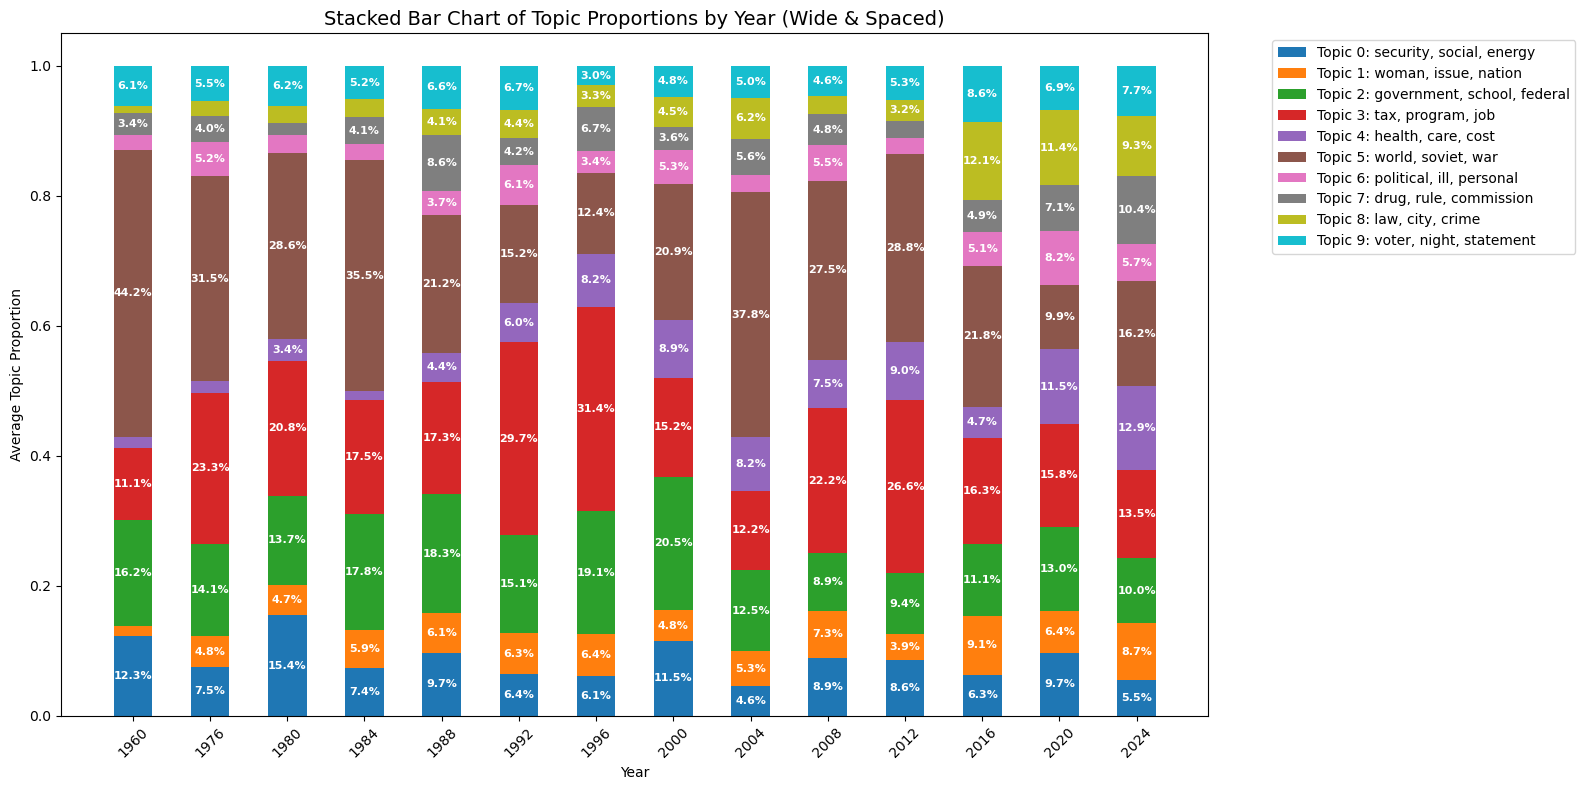

In [69]:
import matplotlib.pyplot as plt

# Prepare labels
legend_labels = []
for topic_id in range(ldaseq_v2.num_topics):
    top_terms = ldaseq_v2.print_topic(topic=topic_id, time=0, top_terms=3)
    short_label = f"Topic {topic_id}: " + ", ".join([term for term, _ in top_terms])
    legend_labels.append(short_label)

# Plot setup
fig, ax = plt.subplots(figsize=(16, 8))
bar_width = 1.5

years = topic_trends_v2.index.tolist()
spacing = 3  # controls how far apart the bars are
x_positions = [i * spacing for i in range(len(years))]  # spread out positions
bottoms = [0] * len(years)

# Draw stacked bars
for i in range(ldaseq_v2.num_topics):
    values = topic_trends_v2[f"Topic {i}"].values
    bars = ax.bar(x_positions, values, width=bar_width, bottom=bottoms, label=legend_labels[i])
    
    # Add % labels
    for j, bar in enumerate(bars):
        height = bar.get_height()
        if height > 0.03:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bottoms[j] + height / 2,
                f"{height*100:.1f}%",
                ha='center',
                va='center',
                fontsize=8,  # ⬅️ increased font size here
                color='white',
                fontweight='bold'
            )
    bottoms = [sum(x) for x in zip(bottoms, values)]

# Customize axes
ax.set_title("Stacked Bar Chart of Topic Proportions by Year (Wide & Spaced)", fontsize=14)
ax.set_xlabel("Year")
ax.set_ylabel("Average Topic Proportion")
ax.set_ylim(0, 1.05)

# Set x-axis labels to actual years, spaced accordingly
ax.set_xticks(x_positions)
ax.set_xticklabels(years, rotation=45)

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# BERTopic per Year

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 22.5 MB/s eta 0:00:0000:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 81.9 MB/s eta 0:00:00:00:0100:01
  Created wheel for hdbscan: filename=hdbscan-0.8.40-cp312-cp312-linux_x86_64.whl size=844868 sha256=afcf272e55e175ed4129449d8a1280dcd1c9caa8ae15230ac5c9007c948a7838
  Stored in directory: /home/ucloud/.cache/pip/wheels/80/e7/bb/173ca0d8ce12718c4b5e6e01619c99653579b56969b97604b2
Successfully built hdbscan
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [bertopic]5/7 [sentence-transformers]


In [ ]:
from bertopic import BERTopic
import pandas as pd

In [ ]:
# Step 1: Drop NA and convert dialogues to string
texts = df_transcripts["dialogue"].dropna().astype(str).tolist()

# Step 2: Instantiate BERTopic model
topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)

# Step 3: Fit the model on raw dialogue
topics, probs = topic_model.fit_transform(texts)

# Step 4: Show top 10 words for each topic
all_topics = topic_model.get_topics()

for topic_id, topic_words in all_topics.items():
    print(f"Topic {topic_id}: {topic_words[:10]}")

2025-05-21 20:33:23,981 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/262 [00:00<?, ?it/s]